In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
import os

In [2]:
path = 'E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/datasets/Retinal OCT Images/OCT2017/train/'

In [3]:
classes = {'CNV':0, 'DME':1, 'DRUSEN':2, 'NORMAL':3}

In [4]:
images = []
labels = []

def load_data(path):
    for folders in os.listdir(path):
        for files in os.listdir(path + folders + '/'):
            image = cv.imread(path + folders + '/' + files)
            if image is None:
                continue
            image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
            image = cv.resize(image, (150, 150))
            image = image.astype('float32')/255.0
            label = classes[folders]
            images.append(image)
            labels.append(label)
    images_r = np.array(images)
    labels_r = np.array(labels)
    
    return images_r, labels_r

In [5]:
images, labels = load_data(path)

In [6]:
images.shape, labels.shape

((83484, 150, 150), (83484,))

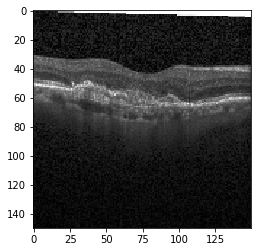

In [7]:
import matplotlib.pyplot as plt

plt.imshow(images[0], cmap='gray')

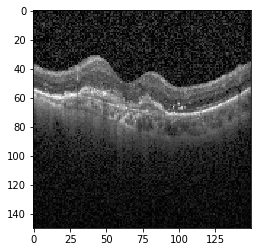

In [8]:
plt.imshow(images[100], cmap='gray')

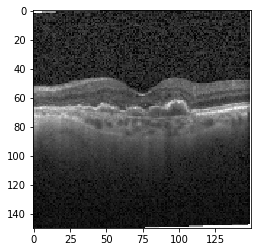

In [9]:
plt.imshow(images[948], cmap='gray')

In [10]:
images = images.reshape((images.shape[0],150, 150, 1))

In [11]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.1, random_state=10)

In [13]:
Y_train_req = to_categorical(Y_train)
Y_test_req = to_categorical(Y_test)

print(X_train.shape, X_test.shape, Y_train_req.shape, Y_test_req.shape)

(75135, 150, 150, 1) (8349, 150, 150, 1) (75135, 4) (8349, 4)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmentor = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, validation_split=0.1)

train_batches = augmentor.flow(X_train, Y_train_req, shuffle=True, subset='training')
val_batches = augmentor.flow(X_train, Y_train_req, subset='validation')

In [15]:
del images
del labels

In [16]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [17]:
model = Sequential()
model.add(Input((150, 150, 1)))

model.add(Conv2D(16, (3,3), padding='same', strides=1, activation='relu'))
model.add(Conv2D(16, (3,3), padding='same', strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2))

model.add(Conv2D(32, (3,3), padding='same', strides=1, activation='relu'))
model.add(Conv2D(32, (3,3), padding='same', strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2))

model.add(Conv2D(64, (3,3), padding='same', strides=1, activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2))

model.add(Conv2D(128, (3,3), padding='same', strides=1, activation='relu'))
model.add(Conv2D(128, (3,3), padding='same', strides=1, activation='relu'))
model.add(Conv2D(128, (3,3), padding='same', strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2))

model.add(Conv2D(256, (3,3), padding='same', strides=1, activation='relu'))
model.add(Conv2D(256, (3,3), padding='same', strides=1, activation='relu'))
model.add(Conv2D(256, (3,3), padding='same', strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        1

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

rlrop = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.3, verbose=2, mode='max')

In [20]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [21]:
steps = 65000/32

history = model.fit_generator(train_batches, validation_data=val_batches, epochs=15, steps_per_epoch=steps, callbacks=[rlrop])

Epoch 1/15
2032/2031 [==============================] - 793s 390ms/step - loss: 0.7487 - accuracy: 0.7390 - val_loss: 0.5814 - val_accuracy: 0.8063
Epoch 2/15
2032/2031 [==============================] - 889s 438ms/step - loss: 0.4418 - accuracy: 0.8581 - val_loss: 0.3866 - val_accuracy: 0.8650
Epoch 3/15
2032/2031 [==============================] - 898s 442ms/step - loss: 0.3251 - accuracy: 0.9059 - val_loss: 0.5848 - val_accuracy: 0.8003
Epoch 4/15
2032/2031 [==============================] - 867s 427ms/step - loss: 0.2744 - accuracy: 0.9206 - val_loss: 0.2849 - val_accuracy: 0.9088
Epoch 5/15
2031/2031 [============================>.] - ETA: 0s - loss: 0.2462 - accuracy: 0.9284
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
2032/2031 [==============================] - 858s 422ms/step - loss: 0.2461 - accuracy: 0.9284 - val_loss: 0.2718 - val_accuracy: 0.9112
Epoch 6/15
2032/2031 [==============================] - 859s 423ms/step - loss: 0.1895 - accu

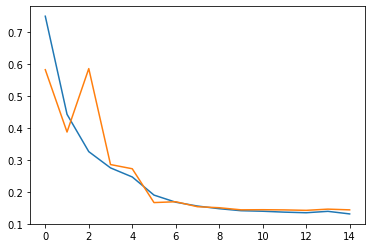

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

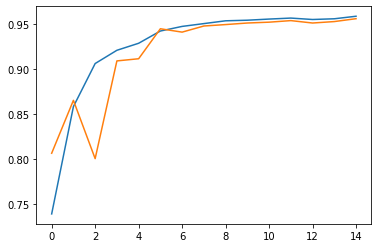

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [24]:
model.evaluate(X_test, Y_test_req)

8349/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.13836875519080424, 0.95232964]